Import libraries

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro

ML libraries

In [22]:
# --- Model selection utilities ---
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

# --- Preprocessing tools ---
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PowerTransformer

# --- Imputation techniques ---
from sklearn.experimental import enable_iterative_imputer #only this enables the iterative imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline

# --- Classification models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# --- Evaluation metrics ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    auc,
)

Import and inspect data

In [23]:
df = pd.read_csv('../data/diabetes.csv')
# Create an overview report
def data_overview(df):
    print(" Dataset Shape:")
    print(f"- Rows: {df.shape[0]}")
    print(f"- Columns: {df.shape[1]}\n")

    print(" Columns and Data Types:")
    print(df.dtypes)
    print("\n")

    print(" Missing Values:")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        print(missing)
    else:
        print("- No missing values detected!")
    print("\n")

    print(" Basic Info:")
    df.info()

    print("\n Sample of Data:")
    display(df.head())

# Run the report
data_overview(df)

 Dataset Shape:
- Rows: 768
- Columns: 9

 Columns and Data Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


 Missing Values:
- No missing values detected!


 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-nul

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Descriptive Statitics

In [24]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Distribution

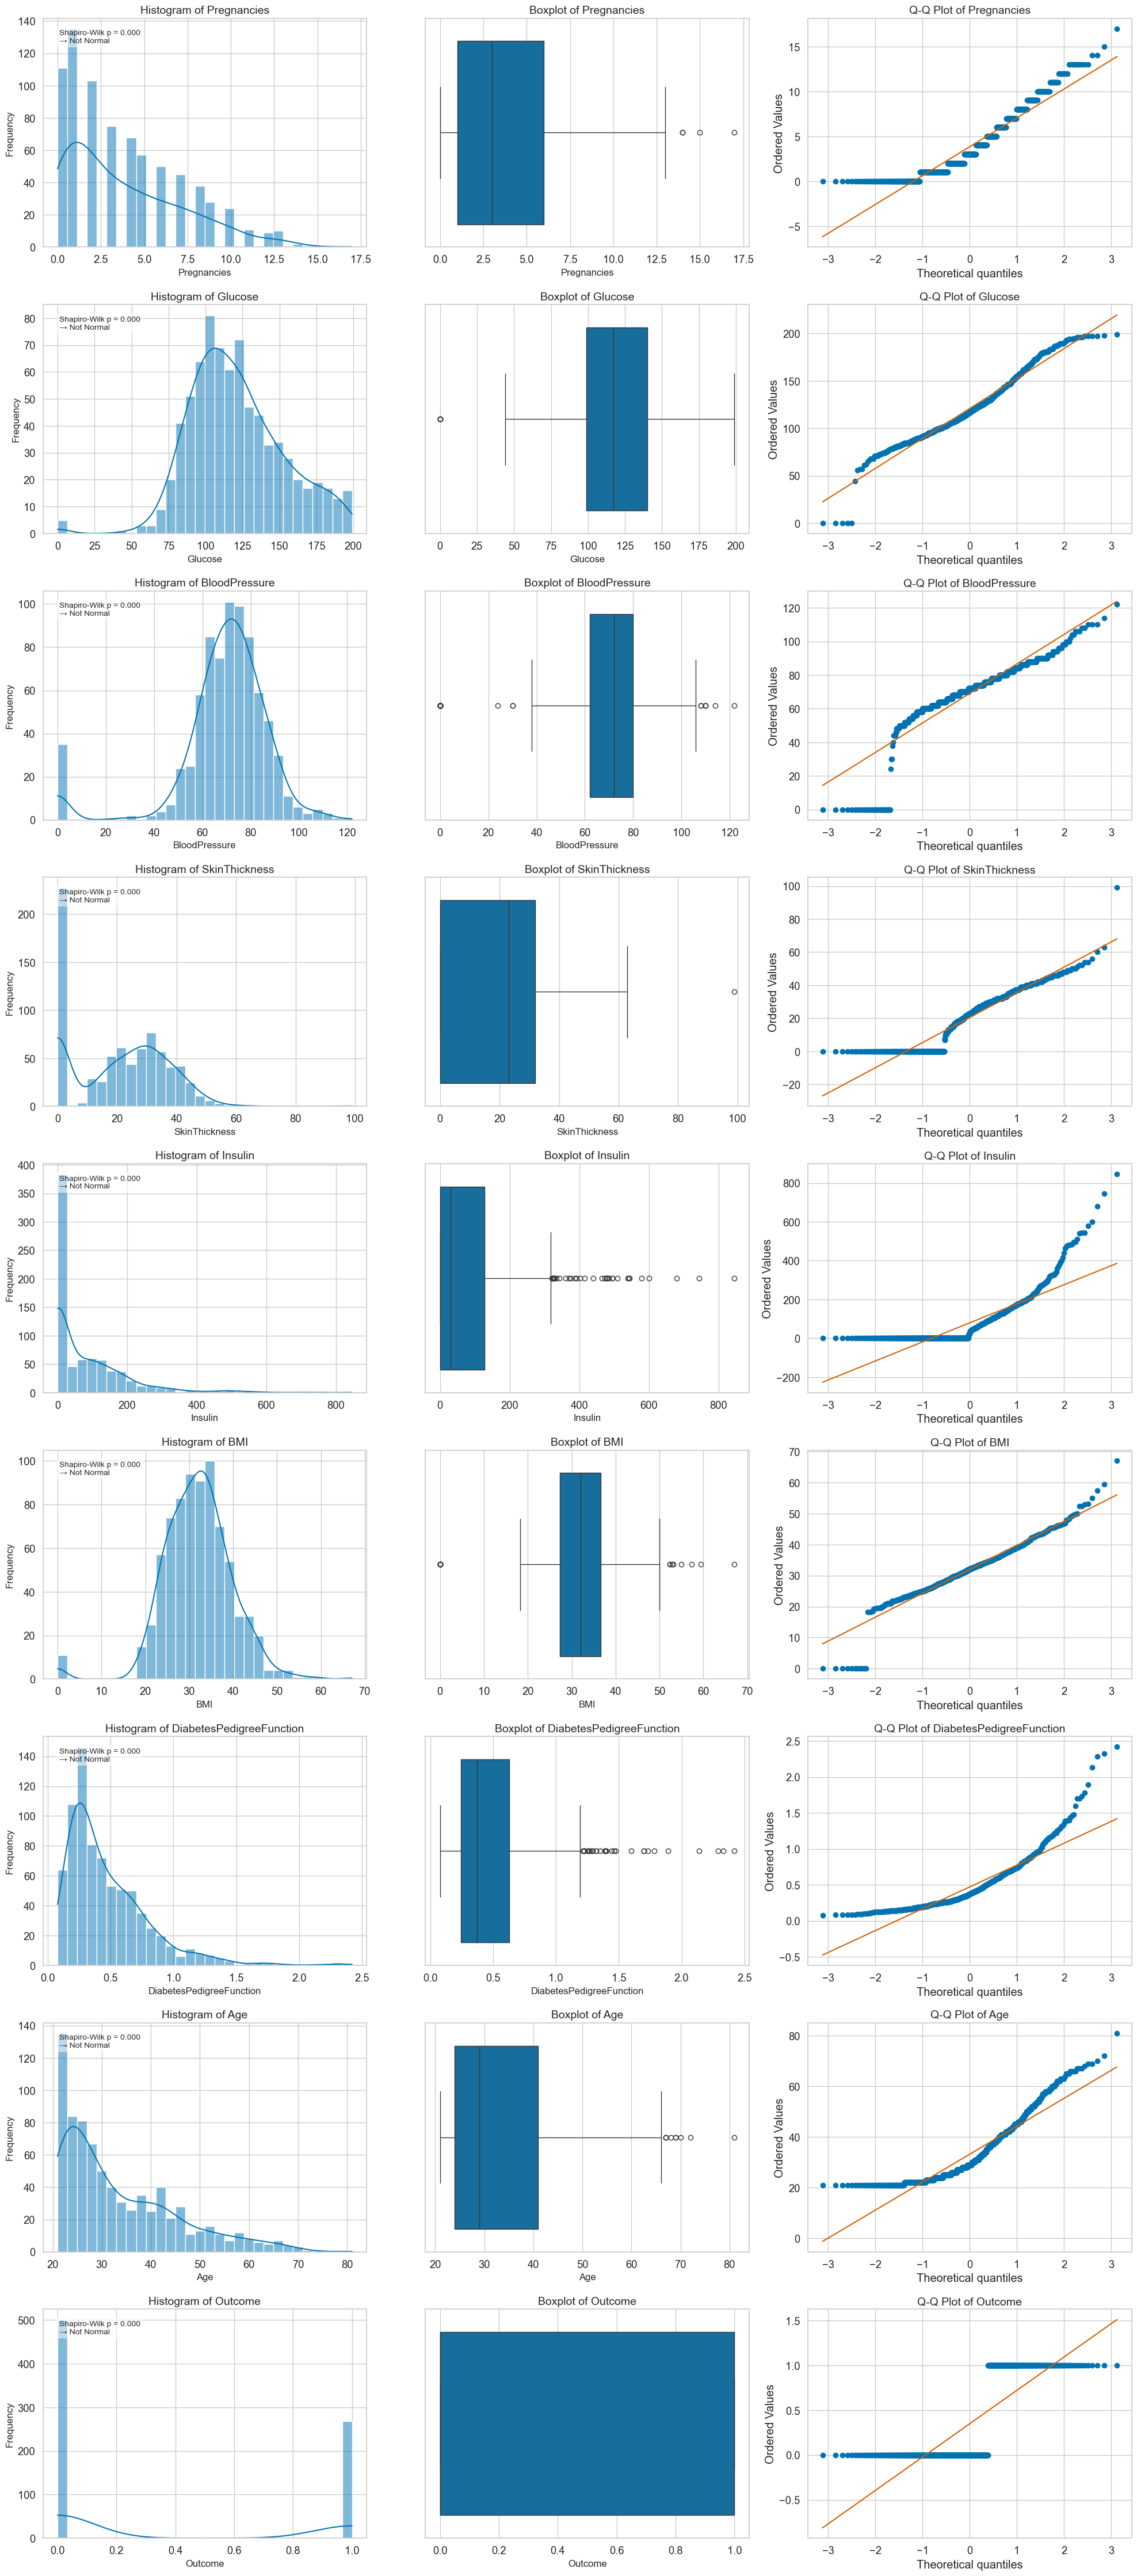

In [25]:
# Set seaborn style and colorblind palette
sns.set(style="whitegrid", palette="colorblind")
sns.set_context('notebook', font_scale=1.2)

#Define num_cols

num_cols = df.columns

# Create one big figure: (rows = number of columns, cols = 3 plots per feature)
fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(20, 5 * len(num_cols)))

# Loop through each numeric column and plot
for idx, col in enumerate(num_cols):

    # 1. Histogram with KDE
    sns.histplot(df[col], kde=True, bins=30, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Histogram of {col}', fontsize=14)
    axes[idx, 0].set_xlabel(col, fontsize=12)
    axes[idx, 0].set_ylabel('Frequency', fontsize=12)

    # Shapiro-Wilk test
    stat, p_value = shapiro(df[col].dropna())
    normality = "Normal" if p_value > 0.05 else "Not Normal"

    # Annotate p-value
    axes[idx, 0].text(0.05, 0.95, f'Shapiro-Wilk p = {p_value:.3f}\n→ {normality}',
                      transform=axes[idx, 0].transAxes,
                      fontsize=10,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # 2. Boxplot
    sns.boxplot(x=df[col], ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Boxplot of {col}', fontsize=14)
    axes[idx, 1].set_xlabel(col, fontsize=12)

    # 3. Q-Q plot
    stats.probplot(df[col].dropna(), dist="norm", plot=axes[idx, 2])
    axes[idx, 2].set_title(f'Q-Q Plot of {col}', fontsize=14)

# Make everything tight and clean
plt.tight_layout()

#Save the plot
plt.savefig('../Figures/dist.png')

# Save the BIG figure
plt.show()

# (Optional) Dis

Detection of Outliers

In [26]:
# Create a dictionary to store outlier indices per column
outliers_iqr = {}

# Loop over each numeric column
for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find the outliers
    outlier_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()

    # Save
    outliers_iqr[col] = outlier_indices

# Print number of outliers per column
for feature, indices in outliers_iqr.items():
    print(f'{feature}: {len(indices)} outliers')


Pregnancies: 4 outliers
Glucose: 5 outliers
BloodPressure: 45 outliers
SkinThickness: 1 outliers
Insulin: 34 outliers
BMI: 19 outliers
DiabetesPedigreeFunction: 29 outliers
Age: 9 outliers
Outcome: 0 outliers


**Part Michael done: no features has normal distribution, take outliers with caution due to the zero (e.g. diabetes: outliners are the actual data points)**


Part Tobias start

Visualize Feature Correlations
Pearson Correlation Matrix

In [27]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


Heatmap to visualize feature dependencies

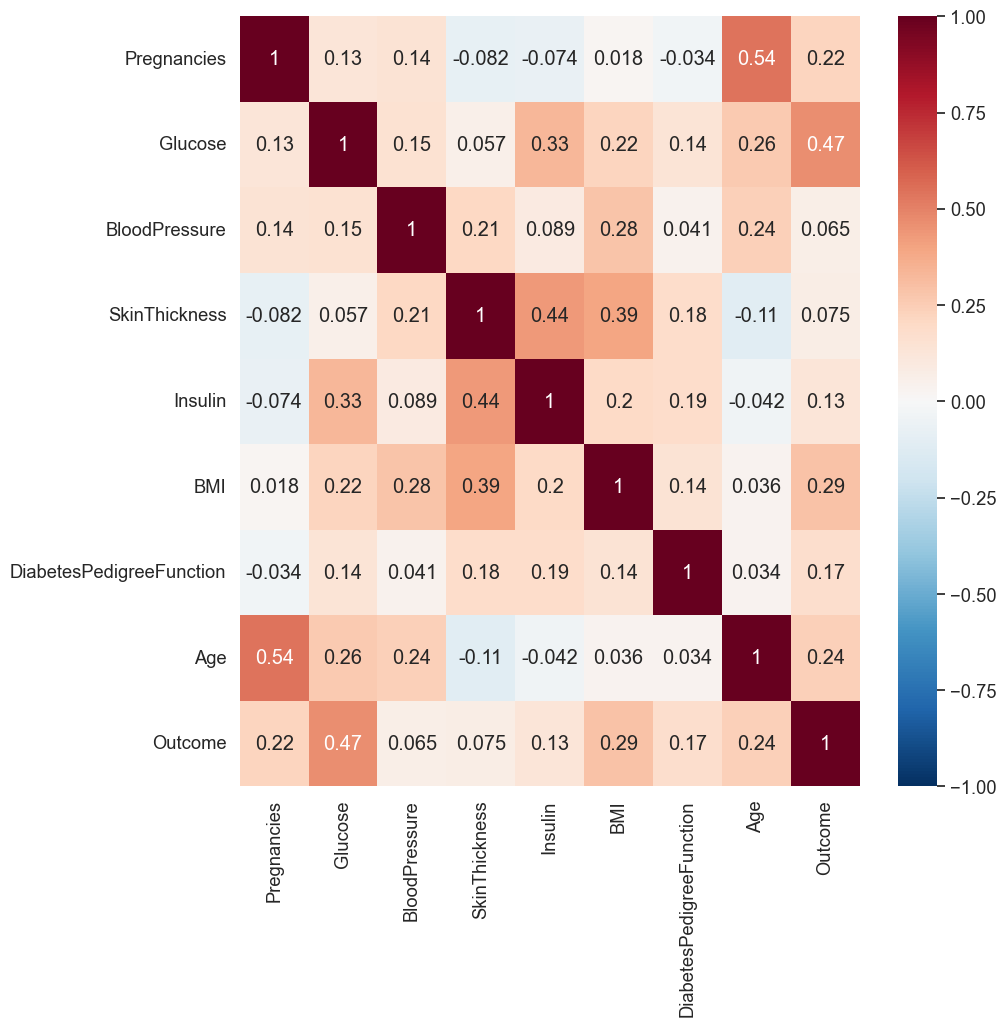

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), vmin=-1.0, center=0, cmap='RdBu_r', annot=True)
plt.show()
plt.savefig('../Figures/corr.png')

Based on the pairwise correlation analysis, the highest correlation observed between predictor features is 0.54, specifically between 'Age' and 'Pregnancies'. While this indicates a moderate positive linear relationship, it falls below the typical thresholds (e.g., ∣r∣>0.7 or 0.8) often used to flag potentially problematic multicollinearity. In conclusion theres no significant redundancy in the features and thus we dont discard any. 

Part Tobias done

Part Robin start

In [29]:
#Handling missing values that are annotated as 0
#First how to detect them
df.describe().T



,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [30]:
#We can see by the summary that the minimum value of some features is 0, which is pyhsiologically not possible.
#The features that are not possible to be 0 are:
#Glucose, BloodPressure, SkinThickness, Insulin, BMI
#For these we want to replace the 0 values with NaN
#Create a copy of the dataframe
df_nan = df.copy(deep= True) #deep copy to avoid changing the original dataframe
df_nan[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df_nan[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

print('Summary of missing values:')
df_nan.isnull().sum()


Summary of missing values:


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

We want to evaluate some imputers to determine which one would preprocess our dataset best. Use Logistic Regresssion (LR) as a probe model to evaluate how well each imputer prepares the data for classifcation tasks. For each imputer, we fit a pipeline (imputer + scaler + LR) and measure ROC AUC score using CV.
The ROC AUC reflects how well LR can separate the classes after imputation, helping us decide which imputer generates the most useful features. Higher ROC AUC indicates better preprocessing quality for later modeling. 

In [31]:
#X and y defined for testing, train_and_split will be done later by Georg with the right imputation done on the whole dataset.
X_eval = df_nan.drop(columns=['Outcome'])
y_eval = df_nan['Outcome']
imputers = {
    'SimpleMedian' : SimpleImputer(strategy='median'),
    'KNNImputer' : KNNImputer(),
    'Iteratiive_BayesRidge' : IterativeImputer(estimator=BayesianRidge(), random_state = 42),
    'Iterative_RandomForest' : IterativeImputer(estimator = RandomForestRegressor(n_estimators = 10, random_state= 42), random_state = 42)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, imputer in imputers.items():
    # Create a pipeline
    pipe = Pipeline([
        ('imputer', imputer),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    scores = cross_val_score(pipe, X_eval, y_eval, cv = cv, scoring = 'roc_auc')
    results[name] = scores
    print(f'{name}: {scores.mean():.3f} +/- {scores.std():.3f}')

    

SimpleMedian: 0.837 +/- 0.020
KNNImputer: 0.838 +/- 0.022
Iteratiive_BayesRidge: 0.837 +/- 0.022


c:\Users\georg\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\georg\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Iterative_RandomForest: 0.837 +/- 0.020


c:\Users\georg\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [32]:
#we can see that the differences are only small. Still, we choose KNNImputer for now, as it is relatively fast.

#Now we can impute the data with KNNImputer but to do so, separate outcome from features to avoid data leakage.
X = df_nan.drop(columns=['Outcome'])
y = df_nan['Outcome']
#Impute the data
imputer = KNNImputer()
X_imputed = imputer.fit_transform(X)

#Apply PowerTransformer (Yeo-Johnson) to normalize skewed features. this is done feature-wise.
transformer = PowerTransformer(method='yeo-johnson', standardize=False) #set standardize to False to keep it as separate step in case we want to change scaler. 
X_transformed = transformer.fit_transform(X_imputed)
#Scale the data
sc = StandardScaler()
X_scaled = sc.fit_transform(X_transformed)

#Convert back to DataFrame and reconstruct whole dataset
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
cleaned_df = pd.concat([X_scaled_df, y.reset_index(drop=True)], axis=1)


In [33]:
#sanity check
print(cleaned_df.describe().T) #std should be 1 or close and mean 0 or close.
print("\n")
print("Summary of missing values:")
print(cleaned_df.isnull().sum())

                          count          mean       std       min       25%  \
Pregnancies               768.0  1.434038e-16  1.000652 -1.603317 -0.833906   
Glucose                   768.0  1.542747e-15  1.000652 -3.782446 -0.703858   
BloodPressure             768.0  3.342234e-16  1.000652 -4.144263 -0.681860   
SkinThickness             768.0  6.418477e-16  1.000652 -2.879584 -0.609090   
Insulin                   768.0  2.498002e-16  1.000652 -3.241416 -0.647260   
BMI                       768.0 -8.766136e-16  1.000652 -2.586057 -0.680353   
DiabetesPedigreeFunction  768.0 -1.202742e-16  1.000652 -2.085751 -0.760996   
Age                       768.0  8.995119e-15  1.000652 -1.480075 -0.852712   
Outcome                   768.0  3.489583e-01  0.476951  0.000000  0.000000   

                               50%       75%       max  
Pregnancies               0.033363  0.813399  2.313547  
Glucose                  -0.040838  0.689563  2.132112  
BloodPressure            -0.022526  0.

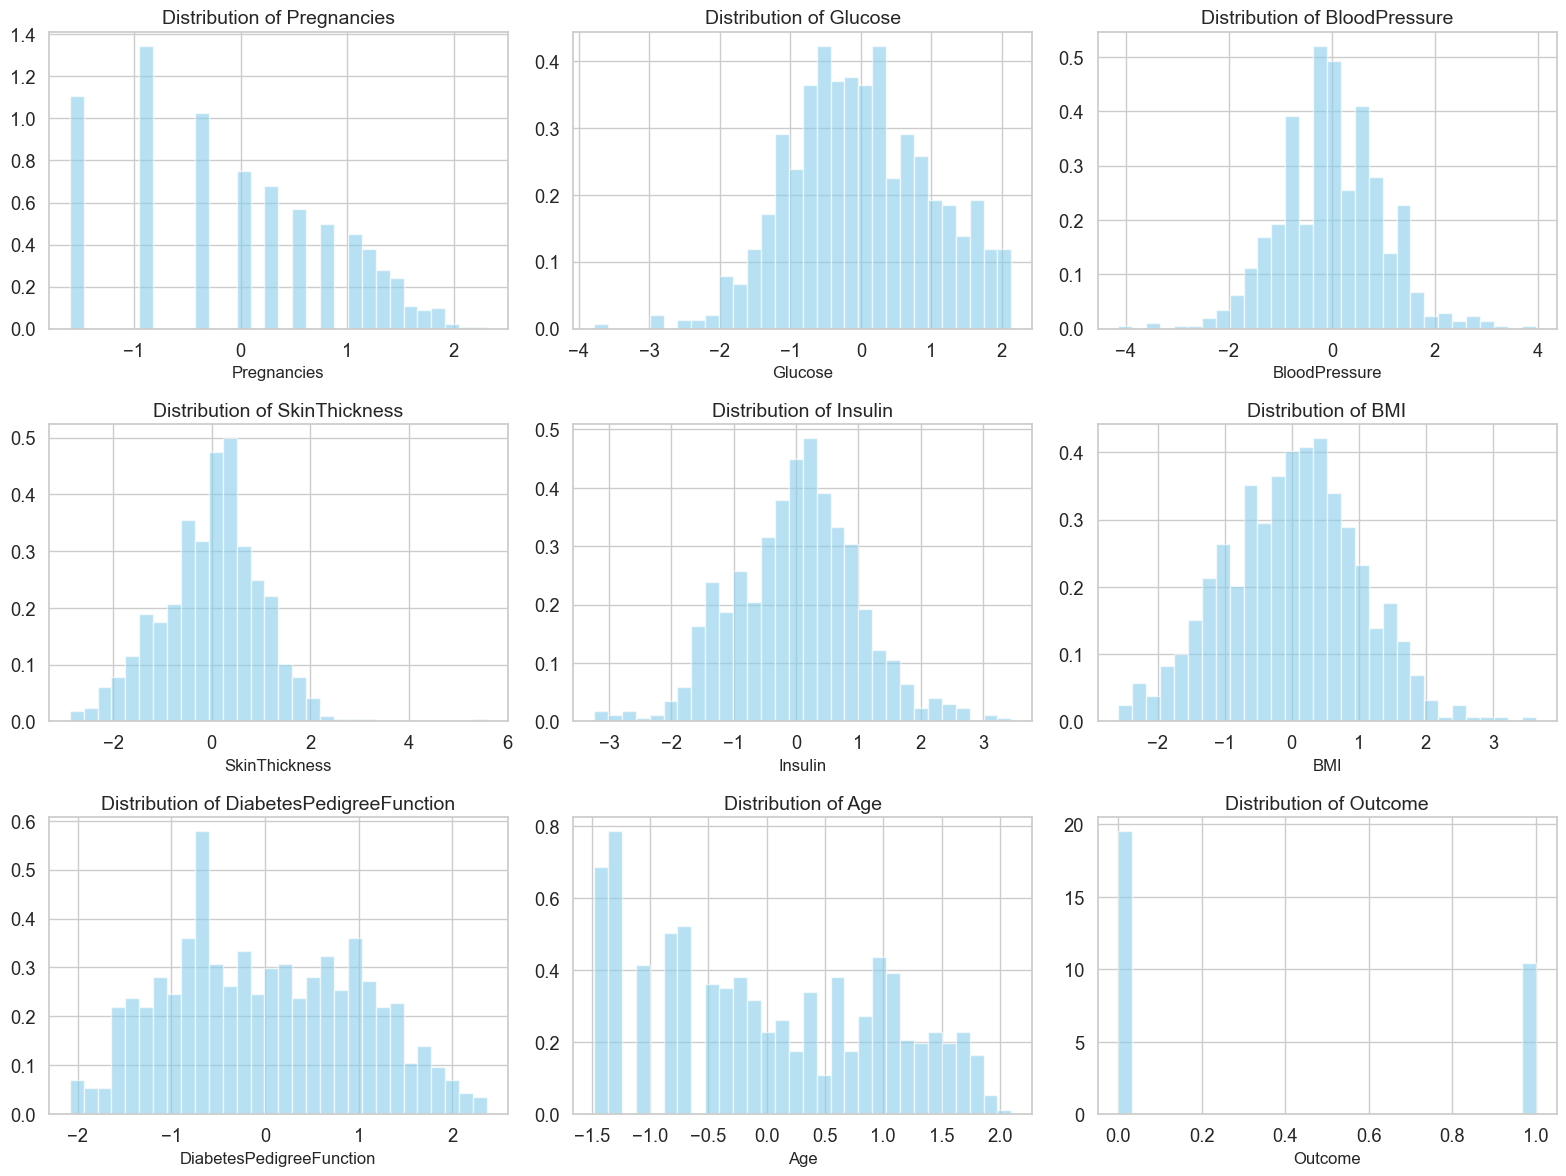

In [34]:
#plot distribution to check post-processing results
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten() #flatten the axes array to make it easier to loop through

for idx, col in enumerate(cleaned_df.columns):
    axes[idx].hist(cleaned_df[col], bins=30, density=True, alpha=0.6, color='skyblue')
    axes[idx].set_title(f'Distribution of {col}', fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)

plt.tight_layout()
plt.show

#save fig
plt.savefig('../Figures/cleaned_dist.png')

So the final plot shows the distribution of each column after imputing, normalizing and scaling the data. The final dataframe is called cleaned_df and can be used now for last steps of preprocessing.

Part Robin done